# Touring the latent space

In [301]:
import torch.nn as nn
import torch
from PIL import Image
import cv2
from tqdm import tqdm

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Interested in automating the process of exploring the latent space, could turn it into a screensaver or something.

## Weighted random walk

In super simplistic terms, a random walk is basically adding to or subtracting from a variable with equal probability (more on [wikipedia](https://en.wikipedia.org/wiki/Random_walk)). Given my use case, I would like the random walk to not take the latent vector too far from 0, which is where it is centered, so that it is possible for the latent vector to continue to provide interesting input to the (currently) `tanh`-based generative network after many iterations. 

Came up with the idea of putting a soft leash on the range of values by weighing the probabilities, so that the further the values are from 0, the more likely it is that the random walk will turn the latent vector back. 

### Softmax-based weighting

First idea that came to mind is to use a softmax to weigh the probabilities. Assume that the latent vector is in 2 dimensions. Thought about specifying a max radius from the origin, which represents the max distance that the latent vector should stray from origin. The distance between the current position of the latent vector and the closest point on the max radius, and the distance between the current position of the latent vector and the farthest point on the max radius can be passed through a softmax to determine the probability of which direction to move in. This easily scales to any number of dimensions. 

Not too sure how the probabilities will work out, can test this empirically. Implementing an example in 1 dimension, where the random walk is used to choose to turn left or turn right on a number line centered at 0:

In [2]:
def softmax(x):
    """
    x is a numpy array with shape (N, )
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [22]:
max_dist = 10
loc_from_left = []
prob_turn_left = []

for pos in np.arange(start=-max_dist, stop=max_dist, step=0.1):
    # Directly specifiying these points here
    # If actually implemented for N-dims, these points can be determined by:
    # (1) calculating current dist to origin vector, keep the unit vector
    # (2) nearest_dist would be -R + magnitude of distance vector
    # (3) farthest_dist would be +R + magnitude of distance vector
    # (4) obtain probabilities are obtained from softmax
    # (5) apply walk in direction of the selected unit vector
    left_dist = pos - (-max_dist)
    right_dist = max_dist - pos
    dists = np.array([left_dist, right_dist])
    probs = softmax(dists)
    
    loc_from_left.append(pos)
    prob_turn_left.append(probs[0])

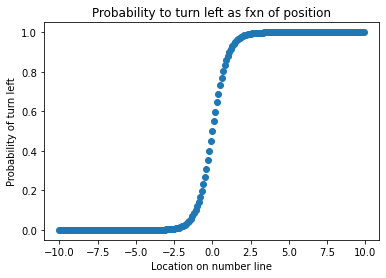

In [23]:
plt.scatter(loc_from_left, prob_turn_left)
plt.title("Probability to turn left as fxn of position")
plt.xlabel("Location on number line")
plt.ylabel("Probability of turn left")
plt.show()

Sigmoid behaviour, 50/50 to turn left or right when at the middle. 

I don't want the probabilities to vary too much, as that will lead to a random walk that doesn't venture out very far. Hmmm. Another problem is that softmax is impacted by scale, so the probabilities don't actually adjust accordingly to the defined `max_dist`.

Dividing the input to softmax by the defined max distance solves both problems. We get inputs to softmax that are always in the range of -1 to 1, allowing us to use any `max_dist`, while also being able to zoom in on the probabilities in the center of the sigmoid.

In [24]:
max_dist = 200  # upping this number to make sure that the scaling works
loc_from_left = []
prob_turn_left = []

for pos in np.arange(start=-max_dist, stop=max_dist, step=0.1):
    # Directly specifiying these points here
    # If actually implemented for N-dims, these points can be determined by:
    # (1) calculating current dist to origin vector, keep the unit vector
    # (2) nearest_dist would be -R + magnitude of distance vector
    # (3) farthest_dist would be +R + magnitude of distance vector
    # (4) obtain probabilities are obtained from softmax
    # (5) apply walk in direction of the selected unit vector
    left_dist = (pos - (-max_dist)) / max_dist
    right_dist = (max_dist - pos) / max_dist
    dists = np.array([left_dist, right_dist])
    probs = softmax(dists)
    
    loc_from_left.append(pos)
    prob_turn_left.append(probs[0])

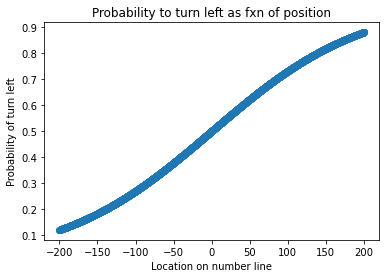

In [25]:
plt.scatter(loc_from_left, prob_turn_left)
plt.title("Probability to turn left as fxn of position")
plt.xlabel("Location on number line")
plt.ylabel("Probability of turn left")
plt.show()

It is possible to take this idea further and introduce a relaxation factor, so that it is possible to zoom in to smaller ranges than (-1, 1) for the softmax input. I imagine that some empirical tuning might be required to get the random walk to behave as intended.

In [26]:
max_dist = 200  # upping this number to make sure that the scaling works
relaxation_factor = 2
loc_from_left = []
prob_turn_left = []

for pos in np.arange(start=-max_dist, stop=max_dist, step=0.1):
    # Directly specifiying these points here
    # If actually implemented for N-dims, these points can be determined by:
    # (1) calculating current dist to origin vector, keep the unit vector
    # (2) nearest_dist would be -R + magnitude of distance vector
    # (3) farthest_dist would be +R + magnitude of distance vector
    # (4) obtain probabilities are obtained from softmax
    # (5) apply walk in direction of the selected unit vector
    left_dist = (pos - (-max_dist)) / (relaxation_factor * max_dist)
    right_dist = (max_dist - pos) / (relaxation_factor * max_dist)
    dists = np.array([left_dist, right_dist])
    probs = softmax(dists)
    
    loc_from_left.append(pos)
    prob_turn_left.append(probs[0])

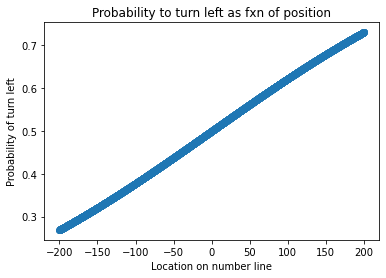

In [27]:
plt.scatter(loc_from_left, prob_turn_left)
plt.title("Probability to turn left as fxn of position")
plt.xlabel("Location on number line")
plt.ylabel("Probability of turn left")
plt.show()

### Implementing 1D weighted random walk

Few changes:
+ Use max and min cord instead of assuming center at zero
+ Implement dist to move as stepsize

In [56]:
def walk1d(init_coord, iterations, stepsize, min_coord, max_coord, relaxation_factor):
    pos_list = [init_coord]
    
    for i in range(iterations):
        current_pos = pos_list[-1]
        
        # Calculate probabilities
        left_dist = (current_pos - min_coord) / (relaxation_factor * (max_coord - min_coord))
        right_dist = (max_coord - current_pos) / (relaxation_factor * (max_coord - min_coord))
        dists = np.array([left_dist, right_dist])
        probs = softmax(dists)
        
        # Sample and walk
        new_pos = current_pos + np.random.choice([-stepsize, +stepsize], p=probs)
        
        # Store
        pos_list.append(new_pos)
    
    return pos_list

In [104]:
pos_list = walk1d(0, iterations=10000, stepsize=0.1, min_coord=-5, max_coord=+5, relaxation_factor=1)

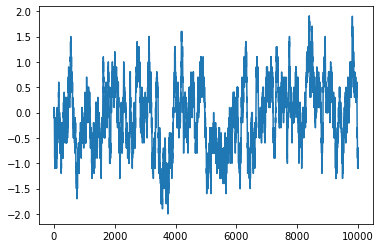

In [105]:
plt.plot(pos_list)

Given the full range of -5 to 5 available, running this a few times show that the random walk indeed has difficulty in breaking out to higher ranges. If the step sizes are made to be small, the random walk stays even closer to zero. Definitely need the relaxation factor.

In [112]:
pos_list = walk1d(0, iterations=10000, stepsize=0.1, min_coord=-5, max_coord=+5, relaxation_factor=10)

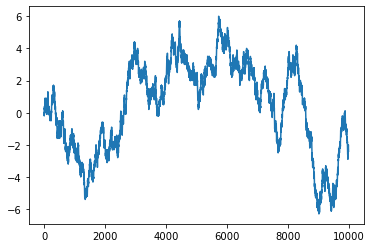

In [113]:
plt.plot(pos_list)

Comparing with a random walk that has no probability weighting:

In [114]:
def walk1d_no_weights(init_coord, iterations, stepsize):
    pos_list = [init_coord]
    
    for i in range(iterations):
        current_pos = pos_list[-1]
        
        # Sample and walk
        new_pos = current_pos + np.random.choice([-stepsize, +stepsize], p=[0.5, 0.5])
        
        # Store
        pos_list.append(new_pos)
    
    return pos_list

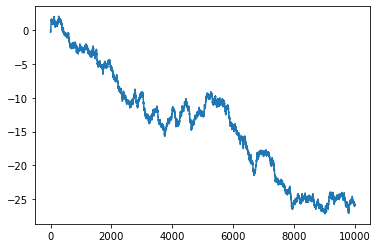

In [124]:
plt.plot(walk1d_no_weights(0, 10000, 0.1))

Yup, wouldn't count on the variance from unweighted random walk.

### Implementing n-dims weighted random walk

Building on this would be to expand to n-dims. Few thoughts:
+ Don't want the n-dims to vary together. Each dim should have it's own dice roll, else there is no point having multiple dims when they are all copies of one dim!
+ Can batch sample all probabilities in a single go, probably will speed up runtime? Just not too sure how to go about it.

In [245]:
# Needs to be redefined since it will be receiving 2D input

def softmax(x):
    """
    Softmax for arrays with shape (dims, N).
    Takes softmax across axis == 1
    Probabilities sum to one over axis=1
    
    Example:
    >>> arr = np.array([[2, 5, 2], [1, 5, 1]])
    >>> softmax(arr, axis=0)
    array([[0.0452785 , 0.01766842],
           [0.909443  , 0.96466316],
           [0.0452785 , 0.01766842]])
    >>> arr.shape
    (2, 3)
    """
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T

In [277]:
def walk_nd(
    dims=3, 
    init_coord=np.array([0, 0, 0]), 
    iterations=1000, 
    stepsize=0.01, 
    min_coord=np.array([-1, -1, -1]), 
    max_coord=np.array([1, 1, 1]), 
    relaxation_factor=20
):
    """
    Random walker for n-dimensions.
    
    Input
    -----
    dims: int
    init_coord: iterable
    iterations: int
    stepsize: int
    min_coord: iterable
    max_coord: iterable
    relaxation_factor: float
    
    Output
    ------
    pos_arr: np.ndarray
    """
    # Check to ensure all inputs have the correct dimensions
    assert len(init_coord) == dims
    assert len(min_coord) == dims
    assert len(max_coord) == dims
    
    # Transform all to numpy array
    if not isinstance(init_coord, np.ndarray):
        init_coord = np.array(init_coord)
        
    if not isinstance(min_coord, np.ndarray):
        min_coord = np.array(min_coord)
        
    if not isinstance(max_coord, np.ndarray):
        max_coord = np.array(max_coord)
    
    # Initialize position array
    pos_arr = np.zeros(shape=(iterations+1, dims))
    pos_arr[0] = init_coord
    
    # Calculate all probabililties up front??
    # sampled_probs = np.random.uniform(low=0, high=1, size=(iterations, dims))
    
    # Iterate to find the probability thresholds
    for i in range(iterations-1):
        current_pos = pos_arr[i+1]
        new_pos = []
        
        # Calculate probabilities for each dimension
        dist_to_min = (current_pos - min_coord) / (relaxation_factor * (max_coord - min_coord))
        dist_to_max = (max_coord - current_pos) / (relaxation_factor * (max_coord - min_coord))
        dists = np.stack([dist_to_min, dist_to_max], axis=1) # this has shape (dims, 2)
        probs = softmax(dists) # also has shape (dims, 2)

        
        for j in range(dims):
            # Calculate distances
            # Sample and walk
            new_pos.append(current_pos[j] + np.random.choice([-stepsize, +stepsize], p=probs[j]))
                
        # Store
        pos_arr[i+2] = new_pos
    
    return pos_arr

In [270]:
pos = walk_nd(dims=3, init_coord=[0, 0, 0], iterations=10000, 
              stepsize=0.01, min_coord=[-1, -1, -1], max_coord=[1, 1, 1], relaxation_factor=20)

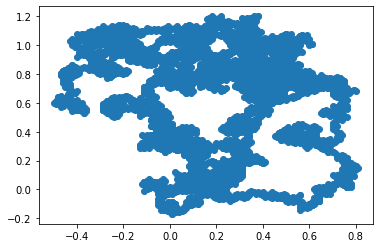

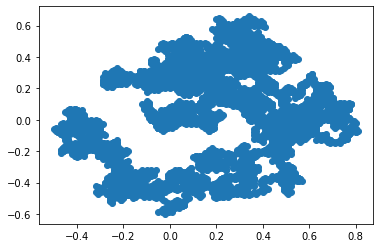

In [271]:
plt.scatter(pos[:, 0], [pos[:, 1]])
plt.show()
plt.scatter(pos[:, 0], [pos[:, 2]])
plt.show()

Yup this is good enough.

## Code from previous notebook with added polish

In [274]:
class Net(nn.Module):
    """
    Describes a generative CPPN that takes `x`, `y`, and optionally distance to origin as input,
    and outputs 3-channel / 1-channel pixel intensity.
    """

    def __init__(
        self,
        num_hidden_layers=4,
        num_neurons=8,
        latent_len=3,
        include_bias=True,
        include_dist_to_origin=True,
        rgb=True,
    ):
        """
        Initializes the CPPN.

        Inputs
        ------
        num_hidden_layers: int
            Number of hidden layers in the network.

        num_neurons: int
            Number of neurons in each hidden layer.

        latent_len: int
            Length of latent vector

        include_bias: bool
            If True, includes bias term in input layer.

        include_dist_to_origin: bool
            If True, includes distance to origin as one of the inputs.

        rgb: bool
            If True, produces 3-channel output. Else, produces 1-channel output.

        Output
        ------
        None
        """
        super(Net, self).__init__()

        # Input layer
        if include_dist_to_origin:
            layers = [
                nn.Linear(3 + latent_len, num_neurons, bias=include_bias),
                nn.Tanh(),
            ]
        else:
            layers = [
                nn.Linear(2 + latent_len, num_neurons, bias=include_bias),
                nn.Tanh(),
            ]

        # Hidden layers
        layers.extend(
            num_hidden_layers
            * [
                nn.Linear(num_neurons, num_neurons, bias=False),
                nn.Tanh(),
            ]
        )

        # Output layer
        if rgb:
            layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        else:
            layers.extend([nn.Linear(num_neurons, 1, bias=False), nn.Sigmoid()])

        # Assign layers to self.layers
        self.layers = nn.Sequential(*layers)

        # Run weight init
        self.init_weights()

    def forward(self, loc_vec, latent_vec):
        """
        `forward` function for the generative network.

        Input
        -----
        loc_vec, latent_vec: torch.Tensor
            Location vector and latent vector.
            Location vector should have shape (N, 2) or shape (N, 3).
            Latent vector should have shape (N, `latent_len`)

        Output
        ------
        x: torch.Tensor
        """
        x = torch.cat([loc_vec, latent_vec], dim=1)
        x = self.layers(x)
        return x

    def _init_weights(self, m):
        """
        Function to apply to the generative network (literally with `Net.apply()`) to initialize
        network weights properly. Required as the default initialization is for deep learning
        training, while we're only interested in starting all layers with a normal distribution.

        Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

        Input
        -----
        m: nn.Modules (I think)

        Output
        ------
        None
        """
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=1)

    def init_weights(self):
        """
        Initializes the weights of the network.

        Input
        -----
        None

        Output
        ------
        None
        """
        self.apply(self._init_weights)

In [275]:
def create_input(img_width, img_height, include_dist_to_origin=True):
    """
    Creates the input for the generative net.

    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool

    Output
    ------
    input_arr: np.ndarray
        Should have shape (img_width * img_height, 2)
    """
    # Create vectors of xs and ys
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)

    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)

    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)
        input_arr = input_arr.reshape(img_width * img_height, 3)
    else:
        input_arr = input_arr.reshape(img_width * img_height, 2)

    return input_arr


In [276]:
def generate_one_art(
    net, latent_vec, input_config={"img_width": 320, "img_height": 320}
):
    """
    Wrapper function to generate a single image output from the given network.

    Input
    -----
    net: Net
    latent_vec: torch.Tensor
    input_config: dict
        Dict of parameters to be passed to `create_input` as kwargs.

    Output
    ------
    net_output: np.ndarray
        Should have shape (y, x, 3) or (y, x, 1)
    """
    # Create input to net, and convert from ndarray to torch.FloatTensor
    net_input = torch.tensor(create_input(**input_config)).float()

    # Create input array from latent_vec, and convert from ndarray to torch.FloatTensor
    latent_vec = np.expand_dims(latent_vec, axis=0)
    latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)
    latent_vec = torch.tensor(latent_vec).float()

    assert net_input.shape == latent_vec.shape

    # Run input through net
    net_output = net(net_input, latent_vec).detach().numpy()

    # Reshape into (y, x, 3) for plotting in PIL
    net_output = net_output.reshape(
        input_config["img_height"], input_config["img_width"], -1
    )

    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

## Explore latent space with random walk

In [315]:
total_seconds = 5
fps = 24
iterations = total_seconds * fps

latent_arr = walk_nd(iterations=iterations, stepsize=0.1, relaxation_factor=100)
net = Net(num_hidden_layers=2, num_neurons=64)

imgs = []

for i in tqdm(range(iterations)):
    out = generate_one_art(net, latent_vec=latent_arr[i], input_config={"img_width": 640, "img_height": 320})
    imgs.append(out)

100%|██████████| 120/120 [00:39<00:00,  3.05it/s]


Save to video:

In [316]:
video = cv2.VideoWriter("../output/rwalk-latent-space.avi", cv2.VideoWriter_fourcc(*'XVID'), 24, (640, 320))
for image in imgs:
    video.write(image)

By hindsight, using random walk to explore the latent space wasn't a particularly good idea. Yes, it covers the latent space well, but the irregular behaviour makes the viewing experience spasmodic rather than elegant. A smooth trajectory in the latent space is much preferred. To work on this more.